<a href="https://colab.research.google.com/github/sanazgit/DeepLearning/blob/main/Noise_Robust_ASR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://github.com/mozilla/DeepSpeech/releases/download/v0.6.1/audio-0.6.1.tar.gz
!tar -xzf audio-0.6.1.tar.gz

In [7]:
!pip install -q torchaudio openai-whisper noisereduce librosa jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.2/803.2 kB 15.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 113.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.8 MB/

In [6]:
import torchaudio
from torchaudio import transforms as T
import torch
import matplotlib.pyplot as plt
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Audio

# **Whisper**

### **Load Data**

In [8]:
y, sr = librosa.load('/content/audio/4507-16021-0012.wav',sr=None)

In [ ]:
Audio(data=y, rate=sr)

In [ ]:
metadata = torchaudio.info('/content/audio/4507-16021-0012.wav')
print(metadata)

AudioMetaData(sample_rate=16000, num_frames=43760, num_channels=1, bits_per_sample=16, encoding=PCM_S)


### **Step 1: Noise Reduction**
We load an audio sample and apply basic denoising using the `noisereduce` library. The goal is to observe whether removing background noise improves ASR model output.


In [9]:
import noisereduce as nr
import soundfile as sf

y_denoised = nr.reduce_noise(y=y, sr=sr, stationary=True)

sf.write('denoised.wav', y_denoised, sr)

In [ ]:
y_dn, sr_dn= librosa.load('/content/denoised.wav',sr=None)
Audio(data=y_dn, rate=sr_dn)

### **Step 2: Feature Extraction**
To visualize the audio properties, we compute the Spectrogram and MFCC (Mel-frequency cepstral coefficients), two common feature representations used in ASR systems.


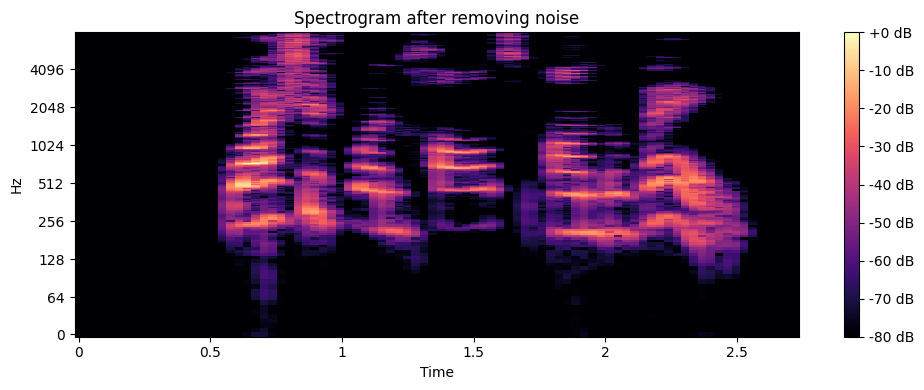

In [ ]:
D = librosa.amplitude_to_db(np.abs(librosa.stft(y_denoised)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.title('Spectrogram after removing noise')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

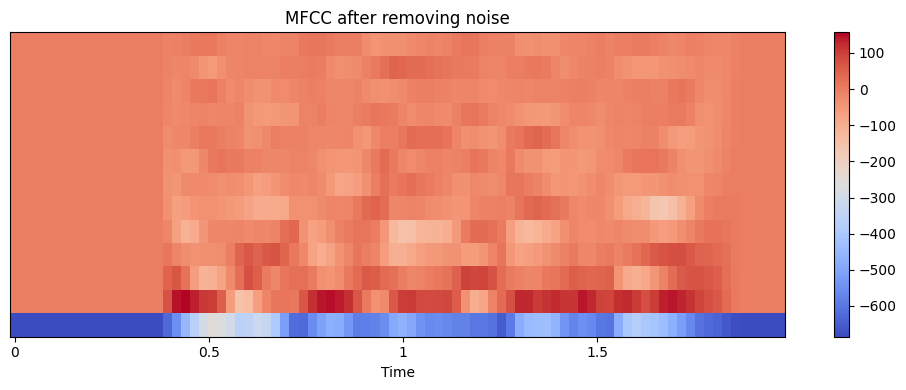

In [ ]:
mfccs = librosa.feature.mfcc(y=y_denoised, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC after removing noise')
plt.tight_layout()
plt.show()


### **Step 3: ASR with Whisper (OpenAI)**
We transcribe both the original and denoised audio files using Whisper to evaluate how noise affects transcription quality.


In [ ]:
import whisper

model = whisper.load_model("base")

result_raw = model.transcribe("/content/audio/4507-16021-0012.wav")
print("🎧 Main Output")
print(result_raw["text"])

result_clean = model.transcribe("denoised.wav")
print("\n🧼 Output after denoising")
print(result_clean["text"])


100%|███████████████████████████████████████| 139M/139M [00:04<00:00, 32.8MiB/s]


🎧 Main Output
 Why should one halt on the way?

🧼 Output after denoising
 Wash it one halt on the way.


### **Wav2Vec2 (HuggingFace)**
We now test the same audio files using Wav2Vec2, a powerful transformer-based ASR model, and compare its performance with Whisper.


In [1]:
!pip install -q transformers datasets soundfile

In [2]:
import torch
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
import soundfile as sf

In [3]:
def transcribe_with_wav2vec2(path):
    speech, rate = sf.read(path)
    input_values = processor(speech, return_tensors="pt", sampling_rate=rate).input_values
    with torch.no_grad():
        logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = processor.decode(predicted_ids[0])
    return transcription

In [4]:
# Load pretrained model and tokenizer
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
# Transcribe original file
raw_text = transcribe_with_wav2vec2("/content/audio/4507-16021-0012.wav")
print("🔊 Wav2Vec2 on RAW:", raw_text)

# Transcribe denoised file
clean_text = transcribe_with_wav2vec2("denoised.wav")
print("🧼 Wav2Vec2 on CLEANED:", clean_text)

🔊 Wav2Vec2 on RAW: WHY SHOULD ONE HALT ON THE WAY
🧼 Wav2Vec2 on CLEANED: WHY SHOULD ONE HALT ON THE WAY
